In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [25]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/user_study/evaluation_study/transcription_and_analysis/"
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

In [26]:
prediction_ground_truth = {
    'Police1': [55.1,4.2,40.7], #ticket,warn,arrest
    'Police2': [53.43,12.02,34.55], #ticket,warn,arrest
    'Autism1': [17.3,82.7], #NO,YES   
    'Autism2': [41,59] #NO,YES   
}

In [27]:
def euclidean_dist(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(np.sum(((x-y)**2)))

In [28]:
def compute_prediction_distances(filename,gt_task_key,aggregate=True):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    
    #Computing Euclidean Distance
    dist_data = []
    for row in prediction.iterrows():
        user_prediction  = row[1][attributes].values
        gt_prediction = prediction_ground_truth[gt_task_key]
        dist_data.append([row[1][task_name],euclidean_dist(user_prediction,gt_prediction)])
    dist_result = pd.DataFrame(dist_data,columns=["Task","Distance"])
    dist_result.groupby("Task",as_index=False)
    if aggregate:
        #mean and standard deviation
        distance_aggregate_result = dist_result.groupby("Task",as_index=False)["Distance"].mean()
        distance_aggregate_result["SD"] = dist_result.groupby("Task",as_index=False)["Distance"].apply(lambda x: x.std())
        return distance_aggregate_result
    else: 
        return dist_result

In [29]:
def compute_prediction_aggregate_stats(filename,gt_task_key,aggregate=True):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    if aggregate:
        prediction_groupby=prediction.groupby(task_name)
        result = prediction_groupby.mean().reset_index()
        std_result = prediction_groupby.apply(lambda x: x.std()).reset_index()
        return result,std_result
    else:
        all_task = ["Task1","Task2"]
        all_task.remove(task_name)
        not_task_name = all_task[0]
        prediction = prediction.drop(not_task_name,axis=1).rename(columns={task_name:"Algorithm"})
        prediction = pd.melt(prediction,id_vars=['Algorithm',"User","Surprisingness"], value_vars=attributes)
        return attributes,prediction

In [31]:
import altair as alt

In [93]:
df = compute_prediction_distances("Prediction1(Autism).csv","Autism1",aggregate=False)
df["Type"] = "Shallow"
df["Dataset"] = "Autism"
df2 = compute_prediction_distances("Prediction1(Police).csv","Police1",aggregate=False)
df2["Type"] = "Shallow"
df2["Dataset"] = "Police"
df3 = compute_prediction_distances("Prediction2(Police).csv","Police2",aggregate=False)
df3["Type"] = "Deep"
df3["Dataset"] = "Police"
df4 = compute_prediction_distances("Prediction2(Autism).csv","Autism2",aggregate=False)
df4["Type"] = "Deep"
df4["Dataset"] = "Autism"

In [94]:
df= pd.concat([df,df2,df3,df4])

In [95]:
df["Condition"] = df["Task"].apply(lambda x: {1:"Storyboard", 2:'Cluster', 3:'BFS'}[int(x[1])])

In [166]:
shallow_df = df[df["Type"]=="Shallow"]
points = alt.Chart(df).mark_point(filled=True).encode(
    alt.X(
        'mean(Distance)',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Distance')
    ),
    alt.Y('Condition'),
    alt.Row('Dataset'),
    alt.Column("Type")
)

error_bars = alt.Chart(df).mark_rule().encode(
    alt.X('ci0(Distance)'),
    alt.X2("ci1(Distance)"),
    alt.Y('Condition'),
    alt.Row('Dataset'),
    alt.Column("Type")
)
# error_bars = alt.Chart(df).mark_rule().encode(
#     x = 'ci0(Distance)',
#     x2 = 'ci1(Distance)',
#     y= 'Task',
#     column = "Type"
# )
# error_ticks= alt.Chart(shallow_df).mark_tick().encode(
#     x='ci0(Distance)',
#     y='Task'
# )
# error_ticks2= alt.Chart(shallow_df).mark_tick().encode(
#     x='ci1(Distance)',
#     y='Task'
# )
# points + error_bars+error_ticks+error_ticks2

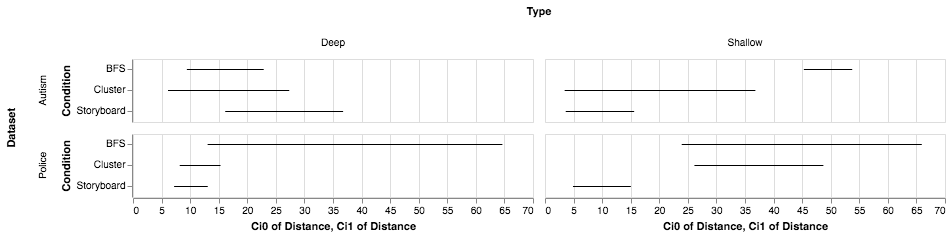

In [167]:
error_bars

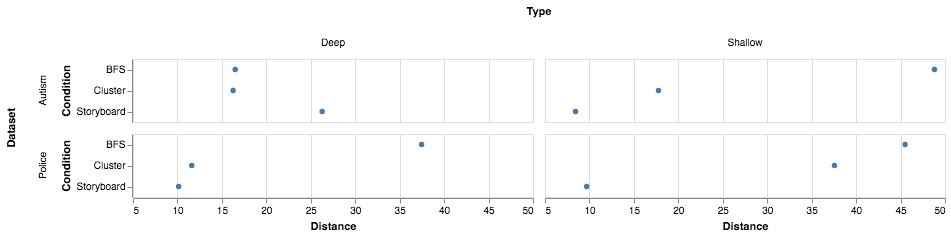

In [168]:
points

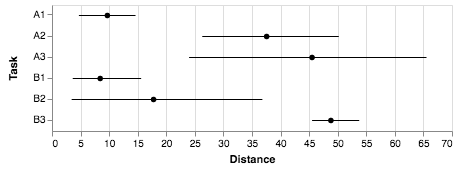

In [70]:
df2 = compute_prediction_distances("Prediction1(Police).csv","Police1",aggregate=False)

points2 = alt.Chart(df2).mark_point(filled=True).encode(
    alt.X(
        'mean(Distance)',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Distance')
    ),
    y='Task',
    color=alt.value('black')
)

error_bars2 = alt.Chart(df2).mark_rule().encode(
    x='ci0(Distance)',
    x2='ci1(Distance)',
    y='Task'
)

points2 + error_bars2 + points + error_bars

In [46]:
err = alt.Chart(df).mark_rule().encode(
    alt.X("Task"),
    alt.Y("SD",scale=alt.Scale(zero=False)),
    alt.Y2("Distance")
)

In [47]:
bar = alt.Chart(df).mark_bar().encode(
    x = alt.X("Task"),
    y = alt.Y("Distance")
)

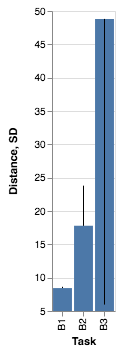

In [48]:
bar + err